In [2]:
import pandas as pd
import numpy as np

# Forecasting

## Importing data

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


In [5]:
df.describe()

,Period,Sales
count,12.000000,12.000000
mean,6.500000,9585.166667
std,3.605551,2674.799460
min,1.000000,5384.000000
25%,3.750000,8017.000000
50%,6.500000,9424.500000
75%,9.250000,10785.250000
max,12.000000,15177.000000


## Visualization

In [6]:
import seaborn as sns
import matplotlib as plt

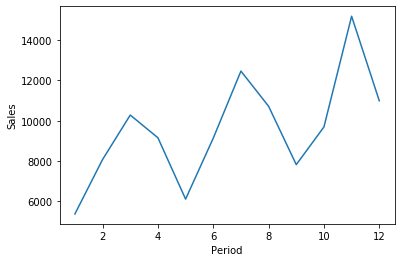

In [7]:
sns.lineplot(x='Period', y='Sales', data=df)

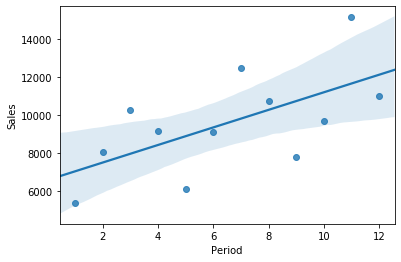

In [8]:
sns.regplot(x='Period', y='Sales', data=df)

We can see the trend of the sales are going upward

## Intepreting data with linear regression

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
X = [[x] for x in df['Period'].values]
y = [[y] for y in df['Sales'].values]

In [11]:
reg = LinearRegression().fit(X, y)

In [12]:
period_predict = [[x] for x in range(13, 17)]
predict_linreg = reg.predict(period_predict)
predict_linreg

array([[12582.21212121],
       [13043.2960373 ],
       [13504.37995338],
       [13965.46386946]])

## Itepreting data with sesionality

### Spliting data into chunks of 4 period

In [13]:
sales_cycles = [df['Sales'].values[i:i+4] for i in range(0, len(df['Sales'].values), 4)]

In [14]:
avg_sales_cycles = [sum(c)/len(c) for c in sales_cycles]

In [15]:
# Calculate the seasionality index for each period in cycle
tmp = list(zip(sales_cycles, avg_sales_cycles))
indices = [[x/i[1] for x in i[0]] for i in tmp]

In [16]:
# Reorganize the indices into list of 1st,2nd,3rd,4th of each cycle
idx_cycles = list(zip(*indices))

### Using linear regression to predict next cycle indices, average value

In [17]:
predict_idx = list()
for i in idx_cycles:
    # Reshape into 2d array
    y = np.array(i).reshape((-1,1))
    X = np.arange(1, 4).reshape((-1,1))
    ss_reg = LinearRegression().fit(X, y)
    predict_idx += list(ss_reg.predict([[4]])[0])
predict_idx

[0.7312134115809197,
 0.8454914809942105,
 1.4518394785162885,
 0.9714556289085812]

In [18]:
y = np.array(avg_sales_cycles).reshape((-1,1))
X = np.arange(1, 4).reshape((-1,1))
ss_reg = LinearRegression().fit(X, y)
predict_avg = ss_reg.predict([[4]])[0][0]

### Calculate next sales value for next cycle

In [19]:
predict_next_cycle = np.array([predict_avg*i for i in predict_idx]).reshape((-1, 1))
predict_next_cycle

array([[ 8979.78816982],
       [10383.1990476 ],
       [17829.55668917],
       [11930.12276008]])

## Evaluation of 2 models

## Import actual data

In [20]:
actual = pd.read_csv('actual.csv')
actual.head()

,Period,Sales
0,13,8050
1,14,11300
2,15,15500
3,16,13000


In [21]:
y_actual = [[y] for y in actual['Sales'].values]

In [22]:
from sklearn.metrics import mean_absolute_error

In [23]:
# Scoring for linear regression without seasionality
mean_absolute_error(y_actual, predict_linreg)

2309.148018648018

In [24]:
# Scoring for linear regression with seasionality
mean_absolute_error(y_actual, predict_next_cycle)

1311.505762826891

We can see the model using seasionality has lower error between predicted values and actual values

# Basics of recommendation system

In [25]:
# Prepare the table
ids = ['ICT', 'Medicine', 'Business', 'Environment']
cols = ['Desperados', 'Guinness', 'chimay triple', 'Leffe']
beer_rating = pd.DataFrame([[4, 3, 2, 3],[1, 2, 3, 1],
    [np.nan, 2, 1, np.nan], [4, 3, np.nan, np.nan]],
    index=ids, columns=cols)
beer_rating

,Desperados,Guinness,chimay triple,Leffe
ICT,4.0,3,2.0,3.0
Medicine,1.0,2,3.0,1.0
Business,NaN,2,1.0,NaN
Environment,4.0,3,NaN,NaN


In [26]:
# Normalize data
rating_normalized = list()
for i, r in beer_rating.iterrows():
    mean = np.mean([i if not np.isnan(i) else 0 for i in r.values])
    rating_normalized += [[x - mean for x in r.values]]
rating_normalized

[[1.0, 0.0, -1.0, 0.0],
 [-0.75, 0.25, 1.25, -0.75],
 [nan, 1.25, 0.25, nan],
 [2.25, 1.25, nan, nan]]

In [27]:
from math import sqrt
def cosine_similarity(vec1, vec2):
    z = zip(vec1, vec2)
    dot = sum([i[0]*i[1] for i in z])
    mag = sqrt(sum([i*i for i in vec1]))*sqrt(sum([i*i for i in vec2]))
    return dot / mag

In [28]:
# Calculate cosine similarity between users
user_sim = list()
for i1, r1 in enumerate(rating_normalized): 
    user = list()
    for i2, r2 in enumerate(rating_normalized):
        if i1 == i2:
            user += [1.0]
            continue
        vec1 = [i if not np.isnan(i) else 0 for i in r1]
        vec2 = [i if not np.isnan(i) else 0 for i in r2]
        user += [cosine_similarity(vec1, vec2)]
    user_sim += [user]
user_sim

[[1.0, -0.8528028654224417, -0.1386750490563073, 0.6181225377691005],
 [-0.8528028654224417, 1.0, 0.2956561979945413, -0.3221390769615825],
 [-0.1386750490563073, 0.2956561979945413, 1.0, 0.4762120735996621],
 [0.6181225377691005, -0.3221390769615825, 0.4762120735996621, 1.0]]

In [ ]:
# Use weighted average to find the score for missing fields
def calculate_score(rating, sim_matrix, row, col):
    if not np.isnan(rating[row][col]):
        return

    sum_w = 0
    sum_avg = 0 
    for i, r in enum(rating):
        if i == row:
            continue
        sum_w = sim_matrix
final_rating = rating_normalized
for i, r in enumerate(final_rating):
    for j, c in enumerate(r):
        if not np.isnan(c):
            continue
        


# Recommender system

In [25]:
users = pd.read_csv("users.csv")
users.head()

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,2460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


In [26]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,user_id,movie_id,rating
0,1,1,3
1,1,3,5
2,1,4,4
3,1,5,3
4,1,6,3


In [27]:
movies = pd.read_csv("movies.csv", encoding='utf-8')
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Preprocess data

In [28]:
users.isnull().sum()

user_id       0
gender        0
age           0
occupation    0
zipcode       0
age_desc      0
occ_desc      0
dtype: int64

In [29]:
ratings.isnull().sum()

user_id     0
movie_id    0
rating      0
dtype: int64

In [30]:
movies.describe()

,movie_id
count,100.000000
mean,50.500000
std,29.011492
min,1.000000
25%,25.750000
50%,50.500000
75%,75.250000
max,100.000000


In [31]:
movies.isna().sum()

movie_id     0
title        0
genres      15
dtype: int64

In [32]:
movies['genres'] = movies['genres'].replace(np.nan, '', regex=True)

In [33]:
movies.isna().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [34]:
movies.describe()

,movie_id
count,100.000000
mean,50.500000
std,29.011492
min,1.000000
25%,25.750000
50%,50.500000
75%,75.250000
max,100.000000


## Get list of genres

In [35]:
genres = list(set([j for i in movies['genres'].unique() if i for j in i.split('|')]))
genres.sort()
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Horror',
 'Musical',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War']

## Vectorize relationship between movies and genres

In [36]:
# Generate vectorization between movies and genres
Ij = list()
for i in movies['genres'].values:
    if not i:
        Ij += [[0]*len(genres)]
        continue

    tmp_dict = {g: 0 for g in genres}
    for j in i.split('|'):
        tmp_dict[j] = 1
    Ij += [[v for k, v in tmp_dict.items()]]
Ij[:4]

[[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

## Vectorize relationship between users and genres

In [37]:
Uj = list()

In [38]:
for i, r in users.iterrows():
    watched_movies = ratings[ratings.user_id == r['user_id']]['movie_id']
    tmp_dict = {k: 0 for k in genres}
    for g in movies[movies.movie_id.isin(watched_movies)]['genres'].values:
        if not g:
            continue
        
        for j in g.split('|'):
            tmp_dict[j] = 1
    Uj += [[v for k, v in tmp_dict.items()]]

In [39]:
Uj[:4]

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

## Compute the consine_similarity

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
movie_user_similarity = list()
# Calculate similarity for each movie in each user
for i in Ij:
    movie_sim = list()
    vec_movie = np.array([i])
    for u in Uj:
        vec_user = np.array([u])
        cosine = cosine_similarity(vec_movie, vec_user)[0][0]
        movie_sim += [cosine]
    movie_user_similarity += [movie_sim]

In [44]:
movie_user_similarity[0]

[0.4629100498862758,
 0.4629100498862758,
 0.447213595499958,
 0.4629100498862758,
 0.4629100498862758,
 0.4629100498862758,
 0.4629100498862758,
 0.447213595499958,
 0.447213595499958,
 0.4629100498862758,
 0.447213595499958,
 0.4629100498862758,
 0.4803844614152615,
 0.4803844614152615,
 0.447213595499958,
 0.447213595499958,
 0.447213595499958,
 0.4629100498862758,
 0.447213595499958,
 0.447213595499958,
 0.4803844614152615,
 0.4803844614152615,
 0.447213595499958,
 0.4629100498862758,
 0.447213595499958,
 0.447213595499958,
 0.447213595499958,
 0.447213595499958,
 0.4629100498862758,
 0.4629100498862758,
 0.447213595499958,
 0.4629100498862758,
 0.447213595499958,
 0.447213595499958,
 0.4629100498862758,
 0.4629100498862758,
 0.4629100498862758,
 0.447213595499958,
 0.447213595499958,
 0.4629100498862758,
 0.4629100498862758,
 0.4803844614152615,
 0.447213595499958,
 0.5000000000000001,
 0.4629100498862758,
 0.4629100498862758,
 0.447213595499958,
 0.4629100498862758,
 0.4472135954

## Collaborative filtering model by user

### Create user - movie rating matrix

In [49]:
# Each row contains rating for each user
# Assume ordered
rating_matrix = list()
for i in movies['movie_id'].values:
    users_rating = [np.nan]*len(users)
    for i, r in ratings[ratings.movie_id == i].iterrows():
        users_rating[r['user_id'] - 1] = r['rating']
    rating_matrix += [users_rating]
rating_matrix[0]

[3,
 3,
 3,
 1,
 2,
 5,
 nan,
 nan,
 4,
 5,
 5,
 nan,
 3,
 4,
 4,
 4,
 nan,
 nan,
 4,
 1,
 nan,
 4,
 nan,
 4,
 3,
 4,
 3,
 4,
 2,
 nan,
 4,
 3,
 nan,
 4,
 nan,
 3,
 nan,
 5,
 2,
 nan,
 4,
 2,
 4,
 3,
 nan,
 5,
 4,
 2,
 5,
 5,
 5,
 4,
 3,
 5,
 4,
 4,
 4,
 3,
 4,
 nan,
 nan,
 3,
 2,
 nan,
 5,
 nan,
 4,
 5,
 5,
 nan,
 2,
 4,
 5,
 4,
 3,
 3,
 3,
 4,
 4,
 5,
 3,
 4,
 5,
 5,
 5,
 2,
 1,
 3,
 5,
 5,
 1,
 nan,
 4,
 4,
 3,
 3,
 4,
 4,
 4,
 4]

In [50]:
~

100